In [24]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Setup device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("⚠ GPU not available, using CPU")

PyTorch version: 2.6.0+cu124
Device: cuda
GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU
GPU Memory: 6.00 GB


## Fetch and clean data

In [25]:
path = os.path.join("../../data", "afras/raw/integrated_data_20251106_213536.csv")
df = pd.read_csv(path)

print("="*60)
print("RAW DATA INFO")
print("="*60)
print(f"Original shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst 3 rows:\n{df.head(3)}")

numeric_columns = ['iteration', 'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3', 
                   'thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky']

for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df_clean = df.dropna(subset=numeric_columns)

print(f"\nRows removed (corrupted/missing data): {len(df) - len(df_clean)}")
print(f"Clean data shape: {df_clean.shape}")

data = df_clean[numeric_columns].values.astype(np.float32)

print(f"\nFinal numeric data shape: {data.shape}")
print(f"Data statistics:\n{pd.DataFrame(data, columns=numeric_columns).describe()}")

RAW DATA INFO
Original shape: (50236, 17)
Columns: ['timestamp', 'iteration', 'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3', 'thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky', 'hand_label']

First 3 rows:
                    timestamp  iteration  env0  raw0  env1  raw1  env2  raw2  \
0  2025-11-06T21:36:41.480070          0   109   497   204   495    41   495   
1  2025-11-06T21:36:41.514994          1    81   501   179   492    48   492   
2  2025-11-06T21:36:41.546769          2    84   496   196   495    55   495   

   env3  raw3  thumb_tip  thumb_base  index  middle  ring   pinky hand_label  
0    21   495     0.9383      0.9656    1.0     1.0   1.0  0.7462       Left  
1    21   492     0.9670      0.9648    1.0     1.0   1.0  0.6877       Left  
2    21   494     0.9388      0.9629    1.0     1.0   1.0  0.8196       Left  

Rows removed (corrupted/missing data): 0
Clean data shape: (50236, 17)

Final numeric data shape: (50236, 15)
Data statistics:
 

In [26]:
sensor_columns = ['env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3']
finger_columns = ['thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky']

sensor_indices = [numeric_columns.index(col) for col in sensor_columns]
finger_indices = [numeric_columns.index(col) for col in finger_columns]

print("="*60)
print("DATA CONFIGURATION")
print("="*60)
print(f"Sensor columns (inputs): {sensor_columns}")
print(f"Sensor indices: {sensor_indices}")
print(f"Number of input features: {len(sensor_indices)}")
print(f"\nFinger columns (outputs): {finger_columns}")
print(f"Finger indices: {finger_indices}")
print(f"Number of output features: {len(finger_indices)}")

DATA CONFIGURATION
Sensor columns (inputs): ['env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3']
Sensor indices: [1, 2, 3, 4, 5, 6, 7, 8]
Number of input features: 8

Finger columns (outputs): ['thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky']
Finger indices: [9, 10, 11, 12, 13, 14]
Number of output features: 6


In [27]:

X = df_clean[sensor_columns].values.astype(np.float32)
y = df_clean[finger_columns].values.astype(np.float32)

# Create scalers
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

print("="*60)
print("NORMALIZATION INFO")
print("="*60)
print("Input feature means (after scaling):", X_scaled.mean(axis=0))
print("Input feature stds (after scaling):", X_scaled.std(axis=0))
print("Output feature means (after scaling):", y_scaled.mean(axis=0))
print("Output feature stds (after scaling):", y_scaled.std(axis=0))


NORMALIZATION INFO
Input feature means (after scaling): [ 1.7009558e-08  1.0934716e-08 -4.2523896e-09 -9.7197477e-09
  5.4673581e-09 -9.7197477e-09 -1.4579622e-08 -9.4160058e-09]
Input feature stds (after scaling): [0.99999994 1.         1.         1.         1.         1.
 1.         1.        ]
Output feature means (after scaling): [ 6.0748424e-09  1.9439495e-08  3.8878991e-08 -4.8598738e-09
  0.0000000e+00 -4.7991254e-08]
Output feature stds (after scaling): [1. 1. 1. 1. 1. 1.]


In [28]:
# save scalars for inference

import joblib

joblib.dump(scaler_X, "scaler_inputs.pkl")
joblib.dump(scaler_y, "scaler_outputs.pkl")


['scaler_outputs.pkl']

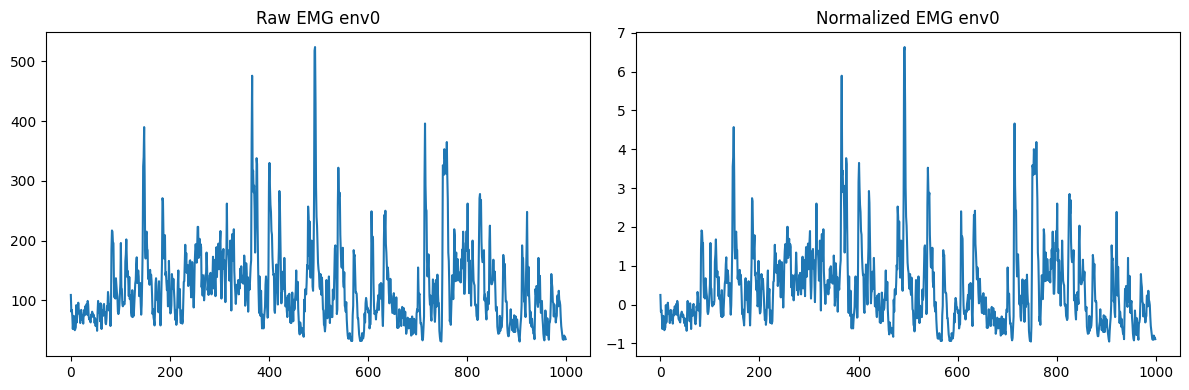

In [29]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Raw EMG env0")
plt.plot(X[:, 0][:1000])  # first 1000 samples
plt.subplot(1, 2, 2)
plt.title("Normalized EMG env0")
plt.plot(X_scaled[:, 0][:1000])
plt.tight_layout()
plt.show()


In [30]:
df_clean['raw_diff01'] = df_clean['raw0'] - df_clean['raw1']
df_clean['raw_diff12'] = df_clean['raw1'] - df_clean['raw2']
df_clean['raw_diff23'] = df_clean['raw2'] - df_clean['raw3']
df_clean['env_diff01'] = df_clean['env0'] - df_clean['env1']
df_clean['env_diff12'] = df_clean['env1'] - df_clean['env2']
df_clean['env_diff23'] = df_clean['env2'] - df_clean['env3']
additional_features = ['raw_diff01', 'raw_diff12', 'raw_diff23', 'env_diff01', 'env_diff12', 'env_diff23']


print(f"\nFinal numeric data shape: {df_clean.shape}")
print(f"Columns after feature engineering: {list(df_clean.columns)}")

sensor_columns = ['env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3',
                  'raw_diff01', 'raw_diff12', 'raw_diff23',
                  'env_diff01', 'env_diff12', 'env_diff23']

X = df_clean[sensor_columns].values.astype(np.float32)

# Normalize each sensor channel separately
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

for i, col in enumerate(sensor_columns):
    df_clean[col + '_norm'] = X_scaled[:, i]



Final numeric data shape: (50236, 23)
Columns after feature engineering: ['timestamp', 'iteration', 'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3', 'thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky', 'hand_label', 'raw_diff01', 'raw_diff12', 'raw_diff23', 'env_diff01', 'env_diff12', 'env_diff23']


In [31]:
import matplotlib.pyplot as plt

def plot_emg_channels(df, channels, title="EMG Channels", n_samples=2000, start=0):
    """
    Plot multiple EMG channels from a DataFrame.

    Args:
        df: pandas DataFrame containing EMG data.
        channels: list of column names to plot.
        title: plot title.
        n_samples: number of samples to display.
        start: index offset (for zooming in later).
    """
    end = start + n_samples
    plt.figure(figsize=(14, len(channels) * 1.4))
    for i, ch in enumerate(channels):
        plt.subplot(len(channels), 1, i + 1)
        plt.plot(df[ch].values[start:end])
        plt.title(ch, fontsize=10, loc='left')
        plt.ylabel("Amplitude")
        plt.grid(True, alpha=0.3)
        if i < len(channels) - 1:
            plt.xticks([])
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


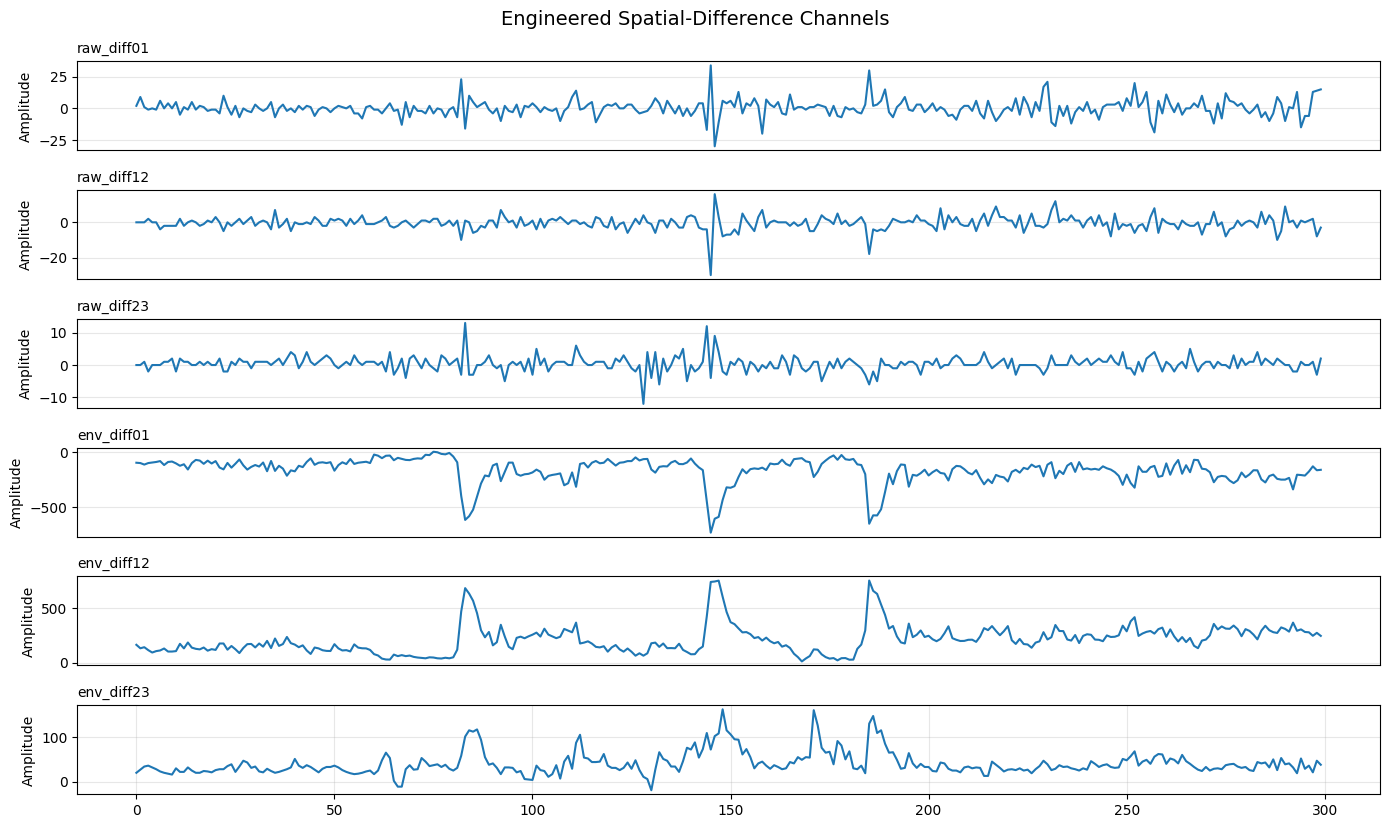

In [32]:


plot_emg_channels(df_clean, 
                  channels=additional_features,
                  title="Engineered Spatial-Difference Channels",
                  n_samples=300)


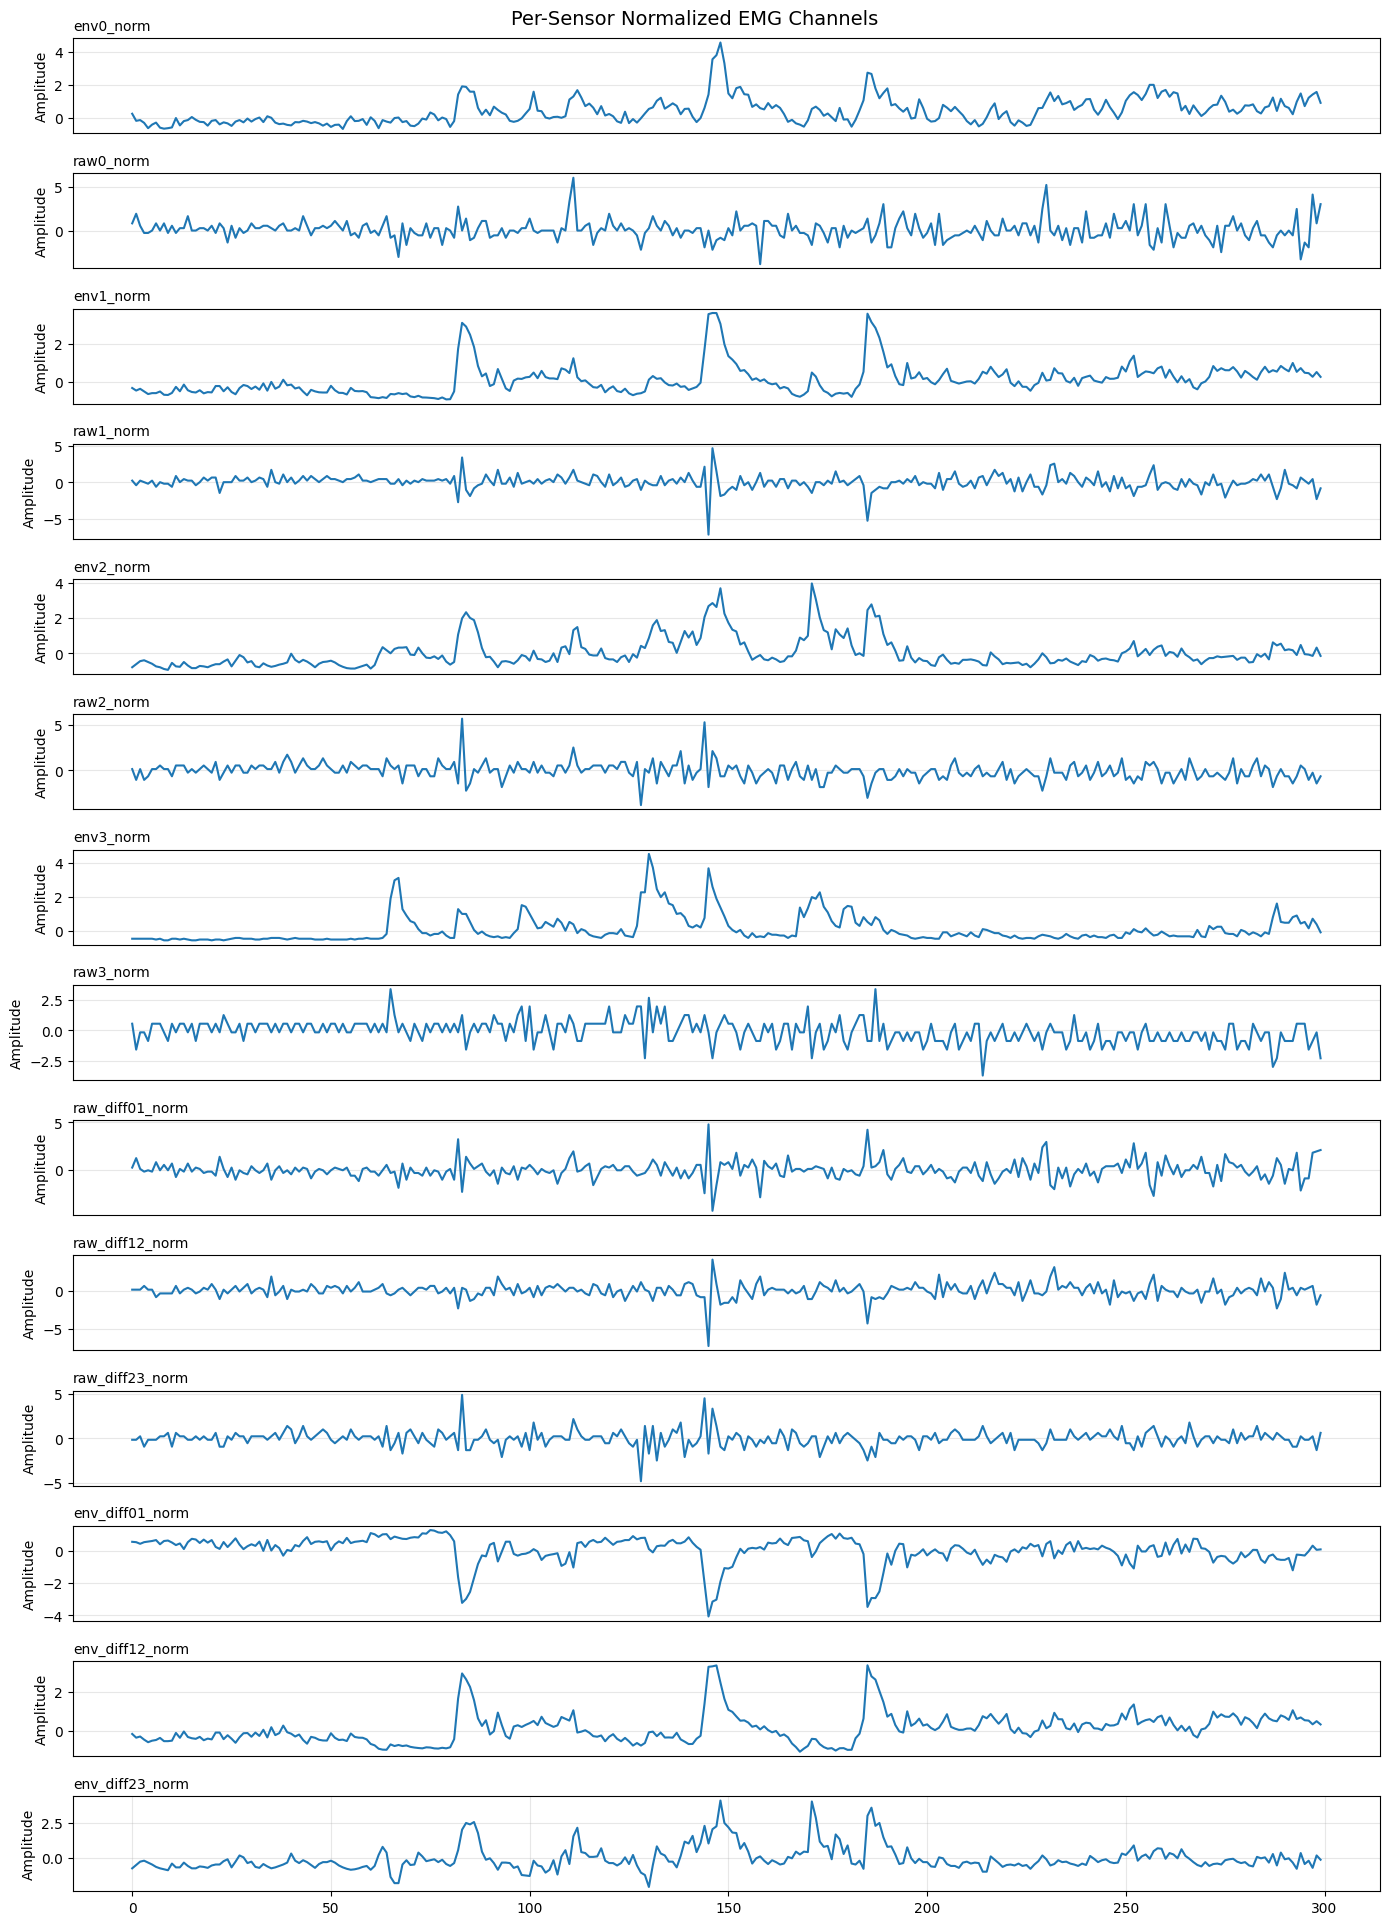

In [34]:
plot_emg_channels(df_clean, [c + '_norm' for c in sensor_columns], 
                  title="Per-Sensor Normalized EMG Channels", n_samples=300)


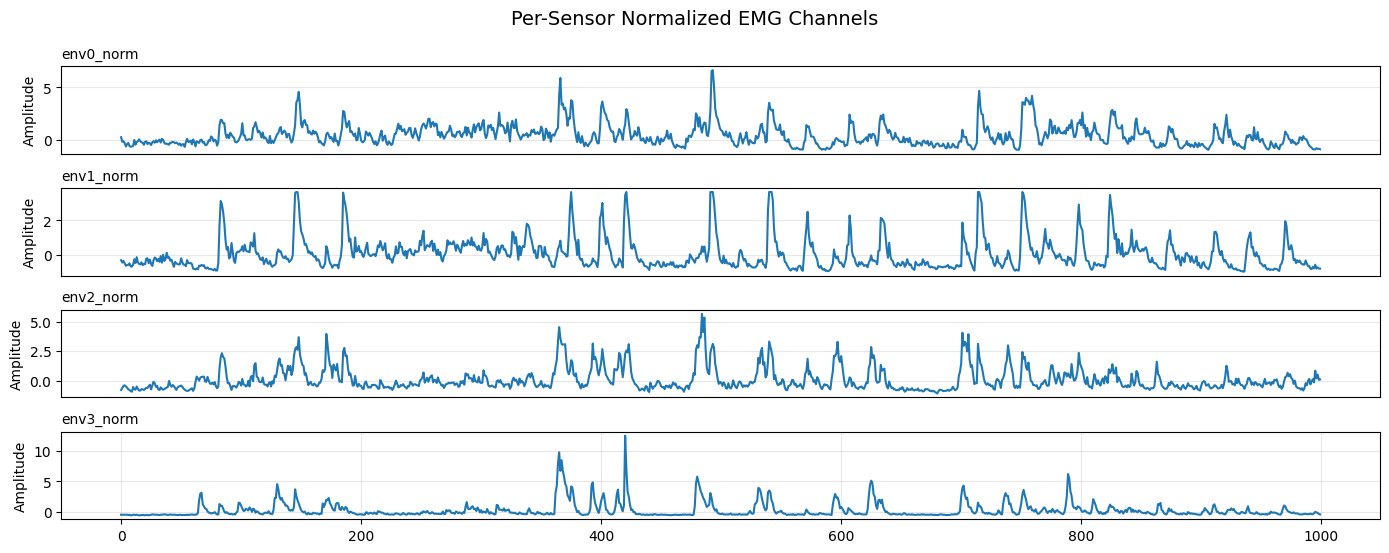

In [36]:
env_columns_norm = ['env0_norm', 'env1_norm', 'env2_norm', 'env3_norm']

plot_emg_channels(df_clean, env_columns_norm, 
                  title="Per-Sensor Normalized EMG Channels", n_samples=1000)